# Set-up

## Imports

In [88]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from NMF_iter import normalize_curves, functional_norm, initialize_W
from scipy.linalg import block_diag
from sklearn.decomposition import NMF

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

%load_ext autoreload
%autoreload 1

%aimport PenNMF
%aimport utils
from utils import plot_components
from PenNMF import PenNMF, _loss_nmf, _loss_constraint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [3]:
specific = '_Italy'

## Functions

# Create data matrix $X$

In [4]:
infile = f'data/2_processed/daily_curves{specific}.csv'
input_df = pd.read_csv(infile, index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2018-01-01_Holiday,24.743000,23.797000,22.175999,21.042000,20.146999,20.079000,20.942001,21.712000,21.969999,22.967000,...,26.643000,26.807000,29.947001,31.103000,31.537000,30.804001,29.621000,27.749000,25.388000,22.714001
2018-01-02_Working day,22.714001,20.794001,19.802002,19.573002,19.679000,20.891000,24.197999,28.537000,32.988000,37.794999,...,36.511999,37.393000,41.395000,42.362001,42.081001,39.555000,37.163000,33.313000,29.811000,26.314001
2018-01-03_Working day,26.314001,24.248999,22.927999,22.537999,22.314001,23.529001,27.206000,32.970999,37.419000,40.908999,...,40.106999,40.662001,44.557000,44.708000,43.818999,41.347000,38.572999,34.229001,30.436999,27.199000


In [5]:
unit_info = input_df.index.str.extract(r'^(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# Drop years for which we don't have indicators
df = df[df.year.astype(int) > 2019]
df_train = df[df.year.astype(int) < 2023]
df_test = df[df.year.astype(int) >= 2023]
print(len(df))
df.head(3)

1461


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,year,month,daytype
2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,29.663000,30.459000,30.347000,29.180,27.406000,24.879000,22.212999,2020,01,Holiday
2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,40.361000,40.117000,38.273000,35.756,32.371000,28.863001,25.324000,2020,01,Working day
2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,41.079001,40.668001,38.369999,35.184,31.951999,28.347001,25.134999,2020,01,Working day


In [6]:
X_train = df_train.drop(unit_info.columns, axis=1)
X_test = df_test.drop(unit_info.columns, axis=1)
X_train = normalize_curves(X_train)
X_test = normalize_curves(X_test)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2020-01-01_Holiday,0.040982,0.039309,0.037369,0.035055,0.033546,0.033640,0.034706,0.036216,0.036113,0.038439,...,0.041075,0.041277,0.047119,0.050026,0.051369,0.051180,0.049212,0.046220,0.041958,0.037462
2020-01-02_Working day,0.029836,0.027394,0.025891,0.025600,0.025746,0.027102,0.031646,0.037646,0.042445,0.047795,...,0.046833,0.047789,0.053384,0.054212,0.053885,0.051408,0.048027,0.043480,0.038768,0.034015
2020-01-03_Working day,0.032524,0.029893,0.027922,0.027265,0.027533,0.028339,0.032455,0.038860,0.043834,0.048315,...,0.046408,0.047624,0.052403,0.052759,0.052231,0.049279,0.045187,0.041037,0.036407,0.032281
2020-01-04_Saturday,0.035505,0.032732,0.031074,0.030431,0.030038,0.031102,0.033951,0.038281,0.041585,0.045738,...,0.043068,0.043740,0.049297,0.051954,0.053135,0.051134,0.046995,0.043196,0.039101,0.034850
2020-01-05_Holiday,0.038522,0.034876,0.032662,0.031490,0.031316,0.031853,0.033533,0.036586,0.037979,0.041645,...,0.041873,0.042782,0.047938,0.051710,0.053156,0.051982,0.048822,0.045577,0.041847,0.037617


In [7]:
cons_df = pd.read_excel('data/1_input/consumption/consumption_chart.xlsx')

# We put agricoltura sector in the industrial one
cons_df['Settore corretto'] = cons_df['Settore corretto'].replace('Agricoltura', 'Industria')
cons_df = pd.pivot_table(cons_df, values='Sum of Consumo corretto', index=['year'], columns='Settore corretto', aggfunc='sum')
cons_df.columns.name = None
cons_df = cons_df.loc[cons_df.index > 2019, ['Servizi', 'Industria', 'Domestico']]

# Align with the consumption computed from the load data
uncorrected_total = cons_df[['Servizi', 'Industria', 'Domestico']].sum(axis=1).values
corrected_total = df_train.groupby(['year'])[[str(i) for i in range(24)]].sum().sum(axis=1).values
cons_df = cons_df.mul(corrected_total / uncorrected_total, axis=0)
cons_df

,Servizi,Industria,Domestico
year,,,
2020,87740.427305,142282.486035,71516.802745
2021,92772.245908,153338.238039,72172.421008
2022,96842.321191,148466.756593,70114.964182


# Create indicators matrix $Y$

In [8]:
imser = pd.read_excel('data/1_input/indicators/IMSER.xlsx')
imser = imser.set_index('Mese').rename({'IMSER (GWh)': 'IMSER'}, axis=1) # We don't have data for this year

imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei = imcei.set_index('Mese').drop('Anno', axis=1).rename({'IMCEI Mensile': 'IMCEI'}, axis=1)

domestic1 = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic2 = pd.read_excel('data/1_input/indicators/Domestico 2022 e 2023.xlsx', skiprows=12, usecols=range(3))
domestic = pd.concat([domestic1, domestic2], ignore_index=True)
domestic = domestic.set_index('Mese').drop('Domestico kWh', axis=1)

indics = imcei.copy()
indics['IMSER'] = imser['IMSER']
indics['EnelDom'] = domestic['Domestico GWh']
indics.head()

,IMCEI,IMSER,EnelDom
Mese,,,
2018-01-01,101.876892,NaN,NaN
2018-02-01,104.070890,NaN,NaN
2018-03-01,112.023582,NaN,NaN
2018-04-01,102.915390,NaN,NaN
2018-05-01,113.072924,NaN,NaN


In [9]:
# Create train and test set
indics_train = indics[(indics.index >= "2020-01-01") & (indics.index <= "2022-12-01")]
indics_test = indics[indics.index > "2022-12-01"]
indics_train

,IMCEI,IMSER,EnelDom
Mese,,,
2020-01-01,95.501727,6788.906354,4741.474351
2020-02-01,102.158558,6130.485292,4120.931091
2020-03-01,83.918607,5075.203065,4571.397146
2020-04-01,67.621478,4084.605248,4056.375574
2020-05-01,98.087167,4895.219550,3817.225967
2020-06-01,98.441420,5818.835023,3712.291417
2020-07-01,105.692110,7479.117252,4493.444176
2020-08-01,67.808602,7378.234005,4878.716921
2020-09-01,104.167368,6687.429054,3832.196697


In [10]:
indics_train.rename(columns={'IMSER': 'Servizi', 'IMCEI': 'Industria', 'EnelDom': 'Domestico'}, inplace=True)
indics_train['year'] = indics_train.index.year
indic_totals = indics_train[['year']].merge(indics_train.groupby('year').sum(), left_on='year', right_index=True, how='left').drop('year', axis=1)
cons_rescaling = indics_train[['year']].merge(cons_df, left_on='year', right_index=True, how='left').drop('year', axis=1)
indics_train.drop('year', axis=1, inplace=True)
Y_train = indics_train.div(indic_totals).mul(cons_rescaling)
Y_train

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6548.498141,12021.927443,8296.596101
2020-02-01,5691.459574,12859.901181,7491.951976
2020-03-01,6313.602794,10563.823677,6202.311207
2020-04-01,5602.301297,8512.312091,4991.720051
2020-05-01,5272.009358,12347.387277,5982.356703
2020-06-01,5127.083190,12391.981269,7111.089982
2020-07-01,6205.941160,13304.710979,9140.089994
2020-08-01,6738.045241,8535.867596,9016.802455
2020-09-01,5292.685585,13112.773830,8172.582581


In [114]:
Y_train.to_pickle('data/2_processed/PenNMF/Y_train.pkl')

# Create parameter matices $B$ and $A$

In [11]:
X_train_unnorm = df_train.drop(unit_info.columns, axis=1)
h = 24 / (X_train_unnorm.shape[1]-1)
norm_X = X_train_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X = pd.DataFrame(norm_X, index=norm_X.index, columns=['norm_X'])
norm_X['month'] = norm_X.index.str[:7]
norm_X

,norm_X,month
2020-01-01_Holiday,592.946498,2020-01
2020-01-02_Working day,744.497504,2020-01
2020-01-03_Working day,778.622499,2020-01
2020-01-04_Saturday,707.928002,2020-01
2020-01-05_Holiday,640.435000,2020-01
...,...,...
2022-12-27_Working day,679.540001,2022-12
2022-12-28_Working day,694.876495,2022-12
2022-12-29_Working day,678.905998,2022-12
2022-12-30_Working day,660.007003,2022-12


In [12]:
m = norm_X.index.str[:7].nunique() # n_months
n = len(X_train) # n_days
blocks = [norm_X.loc[norm_X.month == month, 'norm_X'].values[np.newaxis, :] for month in norm_X.index.str[:7].unique()]
B = block_diag(*blocks)
B.shape

(36, 1096)

In [115]:
with open('data/2_processed/PenNMF/B.pkl', 'wb') as file:
    pickle.dump(B, file)

In [13]:
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])
A.shape

(5, 3)

# PenNMF

## Find suitable alpha parameter

In [105]:
n = len(X_train)
p = len(X_train.columns)
n_components = 5

C_init = initialize_W(X_train, n_components)
S_init = normalize_curves(np.ones((n_components, p)))

loss_nmf = _loss_nmf(X_train, C_init, S_init)
loss_constraint = _loss_constraint(Y_train, B, C_init, A)

print(loss_nmf, loss_constraint)

1.386383896246923 2934439541.256229


In [106]:
# alpha value to make the two losses equal
loss_nmf / loss_constraint

4.724527040872051e-10

In [107]:
tol = 1e-5
max_iter = 10000
verbose = 0
alpha = 5e-10 # rounded
# alpha = 1e-10

model = PenNMF(
    n_components=n_components,
    alpha=alpha,
    tol=tol,
    max_iter=max_iter,
    verbose=0
)

C_init = initialize_W(X_train, n_components)
S_init = normalize_curves(np.ones((n_components, p)))

C = model.fit_transform(X_train.values, C_init.values, S_init, Y_train.values, A, B)

0.01954596907677648


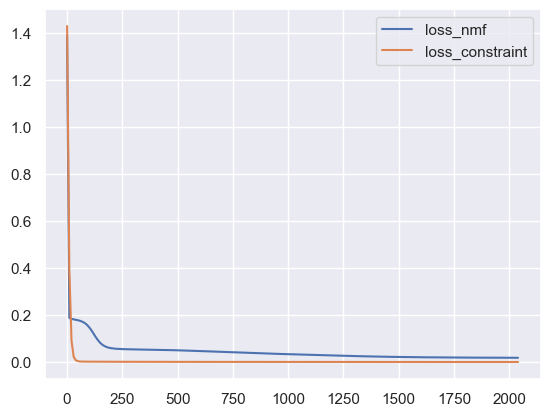

In [108]:
n_iter = model.n_iter_
losses_nmf = model.losses_nmf_
losses_constraint = model.losses_constraint_
plt.plot(np.arange(0, n_iter + 1, 10), losses_nmf, label='loss_nmf')
plt.plot(np.arange(0, n_iter + 1, 10), alpha * np.array(losses_constraint), label='loss_constraint')
# plt.xlim((0, 250))
legend = plt.legend()
print(losses_nmf[-1] + alpha * losses_constraint[-1])

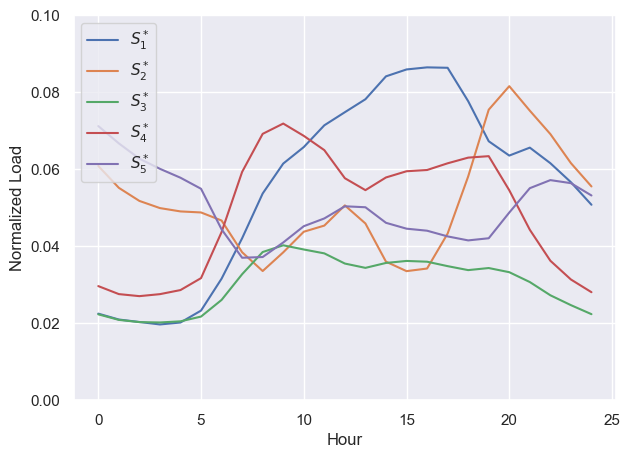

In [109]:
plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.1))

## Compare with NMF

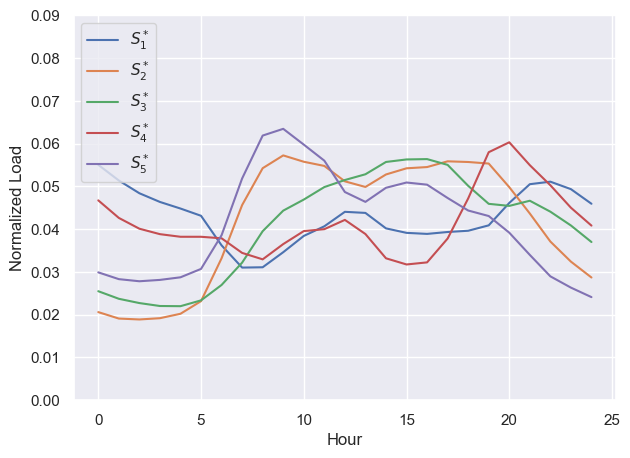

In [94]:
nmf = NMF(
        n_components=n_components,
        solver='mu',
        tol=tol,
        init='custom',
        max_iter=max_iter,
        verbose=verbose
)

C = nmf.fit_transform(
            X_train.values,
            W=C_init.values.copy(order='C'),
            H=S_init
        )

plot_components(model.components_, labels=[f'$S_{i+1}^*$' for i in range(n_components)], marker=None, linewidth=1.5, figsize=(7, 5))
ylim = plt.ylim((0, 0.09))

# Export

<Axes: >

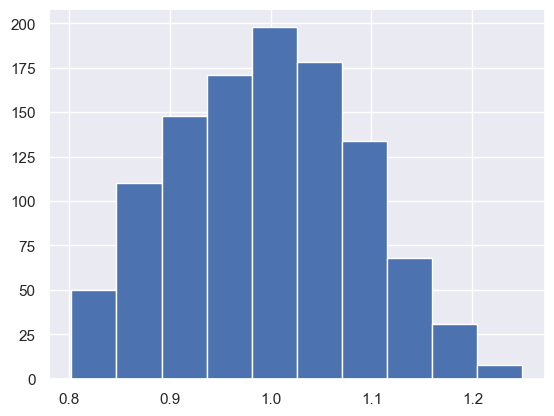

In [113]:
concentrations = pd.DataFrame(C, index=X_train.index)
concentrations.sum(axis=1).hist()

<HR>

# Tests

In [26]:
Y_train

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6548.498141,12021.927443,8296.596101
2020-02-01,5691.459574,12859.901181,7491.951976
2020-03-01,6313.602794,10563.823677,6202.311207
2020-04-01,5602.301297,8512.312091,4991.720051
2020-05-01,5272.009358,12347.387277,5982.356703
2020-06-01,5127.083190,12391.981269,7111.089982
2020-07-01,6205.941160,13304.710979,9140.089994
2020-08-01,6738.045241,8535.867596,9016.802455
2020-09-01,5292.685585,13112.773830,8172.582581


In [88]:
df_train.drop(unit_info.columns, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792000,...,24.355000,24.475000,27.938999,29.663000,30.459000,30.347000,29.180000,27.406000,24.879000,22.212999
2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583000,...,34.867002,35.579000,39.744001,40.361000,40.117000,38.273000,35.756000,32.371000,28.863001,25.324000
2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619000,...,36.133999,37.081000,40.802001,41.079001,40.668001,38.369999,35.184000,31.951999,28.347001,25.134999
2020-01-04_Saturday,25.134999,23.172000,21.998000,21.543000,21.264999,22.018000,24.035001,27.100000,29.439000,32.378999,...,30.489000,30.965000,34.899001,36.780000,37.616000,36.199000,33.269000,30.580000,27.681001,24.671000
2020-01-05_Holiday,24.671000,22.336001,20.917999,20.166999,20.056000,20.400000,21.476001,23.431000,24.323000,26.670999,...,26.817000,27.399001,30.701000,33.117001,34.042998,33.291000,31.267000,29.189001,26.800000,24.091000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27_Working day,21.380998,19.532000,18.675000,18.347001,18.450001,19.371000,22.492000,26.380001,30.207000,33.398001,...,32.708000,32.542999,34.752001,34.971000,34.991001,33.618999,31.192000,28.270999,25.282000,22.515000
2022-12-28_Working day,22.515000,20.515999,19.545999,19.184001,19.163001,20.142999,22.915999,26.823999,30.650999,34.289001,...,32.759999,32.680999,35.343000,35.567000,35.787000,34.269999,31.607001,28.434000,25.439000,22.880000
2022-12-29_Working day,22.880000,20.966000,20.000999,19.533999,19.502001,20.302999,23.024000,26.969000,30.274000,33.133000,...,31.138000,31.788000,34.281000,34.480000,34.605002,33.177000,30.624999,27.697000,24.952001,22.425999
2022-12-30_Working day,22.425999,20.509000,19.494001,19.001002,18.997001,19.890000,22.354000,25.781000,29.032999,31.795000,...,30.025000,30.750000,33.078001,33.695000,33.741002,32.572000,29.723000,27.163999,24.658000,24.126001


In [82]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

In [87]:
norm_X

2020-01-01_Holiday        592.946498
2020-01-02_Working day    744.497504
2020-01-03_Working day    778.622499
2020-01-04_Saturday       707.928002
2020-01-05_Holiday        640.435000
                             ...    
2023-12-27_Working day    693.635004
2023-12-28_Working day    708.211995
2023-12-29_Working day    680.176000
2023-12-30_Saturday       633.401001
2023-12-31_Holiday        602.807502
Length: 1461, dtype: float64

In [24]:
input_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,26643.000,26807.000,29947.001,31103.000,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001
2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,36511.999,37393.000,41395.000,42362.001,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001
2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,40106.999,40662.001,44557.000,44708.000,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000
2018-01-04_Working day,27199.000,25051.000,23787.000,23393.000,23543.002,24245.999,27503.000,32829.000,37192.999,40642.001,...,39035.000,40634.000,43444.001,43907.999,43327.999,41224.999,38268.001,34536.000,31038.998,27480.999
2018-01-05_Working day,27480.999,24941.000,23812.000,23415.999,23451.999,24635.000,27835.999,32999.000,37638.000,41426.000,...,40035.000,40702.000,43605.000,44255.999,43896.001,41364.000,38071.001,34230.000,30616.999,27666.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27_Working day,21685.000,19723.000,18836.000,18384.000,18459.000,19524.001,22772.999,26960.000,30677.001,33801.001,...,33613.000,33464.000,35673.000,35975.000,36113.001,34647.002,32146.999,29044.000,26019.000,23158.999
2023-12-28_Working day,23158.999,21259.001,20085.000,19662.000,19627.000,20618.999,23666.001,27621.999,31179.999,34103.999,...,33531.000,33846.000,36305.000,36175.999,36213.000,34765.999,32186.000,29002.999,25709.001,22783.000
2023-12-29_Working day,22783.000,20807.001,19813.999,19364.999,19351.001,20237.000,22792.000,26339.000,29453.000,32417.999,...,31834.001,31946.001,34287.000,34664.000,34800.000,33160.000,30876.999,28225.001,25329.999,22629.000
2023-12-30_Saturday,22629.000,20789.999,19718.999,19234.000,19138.000,19780.001,21512.001,24080.000,26029.999,28430.001,...,27979.999,28876.998,32021.999,33344.001,34088.999,32942.002,30398.000,28059.000,25597.001,22839.000


(0.0, 5500.0)

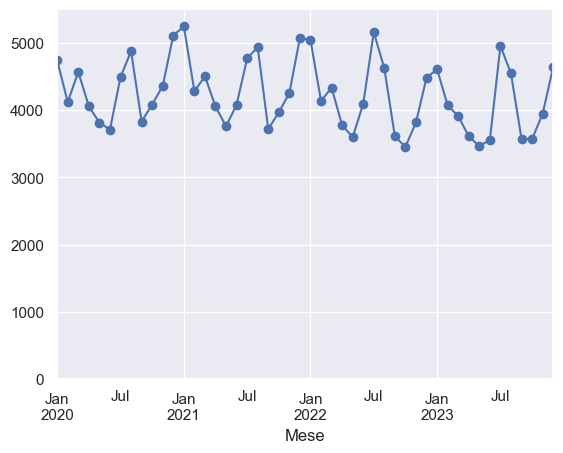

In [10]:
domestic.set_index('Mese')['Domestico GWh'].plot(marker='o')
plt.ylim((0, 5500))

In [17]:
indics.head(50)

,IMCEI,IMSER,EnelDom
Mese,,,
2018-01-01,101.876892,NaN,NaN
2018-02-01,104.070890,NaN,NaN
2018-03-01,112.023582,NaN,NaN
2018-04-01,102.915390,NaN,NaN
2018-05-01,113.072924,NaN,NaN
2018-06-01,111.093813,NaN,NaN
2018-07-01,115.134360,NaN,NaN
2018-08-01,75.716703,NaN,NaN
2018-09-01,113.497008,NaN,NaN
